---
<h1 align="center"><strong>Semantic Similarity CamemBERT+MeanPooling / CamemBERT+LSTM</strong><h1>
<h2 align="center"><b>----Cross Encoder---</strong><h2>

---

In [ ]:
!pip install transformers -q
!pip install SentencePiece -q
!pip install datasets -q

     |████████████████████████████████| 4.4 MB 15.1 MB/s 
     |████████████████████████████████| 86 kB 6.2 MB/s 
     |████████████████████████████████| 596 kB 66.7 MB/s 
     |████████████████████████████████| 6.6 MB 50.2 MB/s 
     |████████████████████████████████| 1.2 MB 16.4 MB/s 
     |████████████████████████████████| 362 kB 9.8 MB/s 
     |████████████████████████████████| 212 kB 31.6 MB/s 
     |████████████████████████████████| 1.1 MB 30.6 MB/s 
     |████████████████████████████████| 140 kB 53.0 MB/s 
     |████████████████████████████████| 127 kB 76.1 MB/s 
     |████████████████████████████████| 144 kB 54.8 MB/s 
     |████████████████████████████████| 271 kB 14.3 MB/s 
     |████████████████████████████████| 94 kB 4.0 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which i

### Required libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from datasets import load_dataset

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import transformers
from transformers import AdamW, get_linear_schedule_with_warmup

from sklearn import model_selection, metrics

from tqdm import tqdm
from collections import defaultdict

import warnings
warnings.filterwarnings("ignore")

from torch.nn import BCEWithLogitsLoss, CrossEntropyLoss, MSELoss
import scipy

### Utils

In [ ]:
def convert_dataset(dataset):
  dataset_samples= pd.DataFrame(columns = ["sentence1","sentence2", "similarity_score"])
  for df in dataset:
    score = float(df['similarity_score'])/5.0
    dataset_samples = dataset_samples.append(df, ignore_index = True)
  dataset_samples['similarity_score']= dataset_samples.apply(lambda col: float(col.similarity_score)/5.0, axis=1)
  return dataset_samples

def get_sts_df(df_train, df_valid, df_test):
  train_samples = convert_dataset(df_train)
  dev_samples = convert_dataset(df_valid)
  test_samples = convert_dataset(df_test)

  #df = pd.concat([train_samples, dev_samples, test_samples], axis=0)
  df = pd.concat([train_samples, dev_samples], axis=0)
  df.reset_index(drop=True, inplace=True)
  #df["similarity_score"] = df["similarity_score"].apply(lambda score: 1 if score> 0.5 else 0)
  return df, test_samples

In [ ]:
df_train = load_dataset("stsb_multi_mt", name="fr", split="train")
df_valid = load_dataset("stsb_multi_mt", name="fr", split="dev")
df_test = load_dataset("stsb_multi_mt", name="fr", split="test")

df, test_samples = get_sts_df(df_train, df_valid, df_test)
df.to_csv("sts.csv")

Generating train split:   0%|          | 0/5749 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1379 [00:00<?, ? examples/s]

Generating dev split:   0%|          | 0/1500 [00:00<?, ? examples/s]

Dataset stsb_multi_mt downloaded and prepared to /root/.cache/huggingface/datasets/stsb_multi_mt/fr/1.0.0/a5d260e4b7aa82d1ab7379523a005a366d9b124c76a5a5cf0c4c5365458b0ba9. Subsequent calls will reuse this data.


Reusing dataset stsb_multi_mt (/root/.cache/huggingface/datasets/stsb_multi_mt/fr/1.0.0/a5d260e4b7aa82d1ab7379523a005a366d9b124c76a5a5cf0c4c5365458b0ba9)
Reusing dataset stsb_multi_mt (/root/.cache/huggingface/datasets/stsb_multi_mt/fr/1.0.0/a5d260e4b7aa82d1ab7379523a005a366d9b124c76a5a5cf0c4c5365458b0ba9)


In [ ]:
class Config:
  #MAX_LEN = 90
  MAX_LEN = 128
  TRAIN_BATCH_SIZE = 8
  VALID_BATCH_SIZE = 4
  EPOCHS = 2
  DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

  CamemeBERT_PATH = "camembert-base"
  MODEL_PATH = "stscamembertModel.bin"
  MODEL_LSTM_PATH = "stscamembertLstmModel.bin"
  TRAINING_DATA = "sts.csv"

  TOKENIZER = transformers.CamembertTokenizer.from_pretrained(CamemeBERT_PATH, do_lower_case = True)
  MODEL = transformers.CamembertModel.from_pretrained(CamemeBERT_PATH, return_dict=False)

Downloading:   0%|          | 0.00/792k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/508 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/424M [00:00<?, ?B/s]

Some weights of the model checkpoint at camembert-base were not used when initializing CamembertModel: ['lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing CamembertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing CamembertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


### Dataset

In [ ]:
class DataProcess:
  def __init__(self, sent1, sent2):
    self.tokenizer = Config.TOKENIZER
    self.max_len = Config.MAX_LEN

    self.sent1 = sent1
    self.sent2 = sent2
    
  def preprocess_bert(self):
    sent1 = " ".join(self.sent1.split())
    sent2 = " ".join(self.sent2.split())
    inputs = self.tokenizer.encode_plus(
        sent1,
        sent2,
        add_special_tokens=True,
        max_length=self.max_len,
        # padding = "max_length",
        truncation=True
        )

    input_ids = inputs["input_ids"]
    attention_mask = inputs["attention_mask"]

    return (
        torch.tensor(input_ids, dtype=torch.long).unsqueeze(0),
        torch.tensor(attention_mask, dtype=torch.long).unsqueeze(0)
        )
    
  def preprocess_output(self, outputs):
    outputs = outputs.cpu().detach().numpy()
    return outputs


class STS:
  def __init__(self,  sent1, sent2, label):
    self.sent1 = sent1
    self.sent2 = sent2
    
    self.label = label
    self.max_len = Config.MAX_LEN
    self.tokenizer = Config.TOKENIZER
  
  def __len__(self):
    return len(self.sent1)
  
  def __getitem__(self, item):
    sent1 = str(self.sent1[item])
    sent1 = " ".join(sent1.split())

    sent2 = str(self.sent2[item])
    sent2 = " ".join(sent2.split())

    inputs = self.tokenizer.encode_plus(
        sent1,
        sent2,
        add_special_tokens=True,
        max_length=self.max_len,
        padding="max_length",
        truncation=True
    )

    input_ids = inputs["input_ids"]
    attention_mask = inputs["attention_mask"]

    return {
        "input_ids" : torch.tensor(input_ids, dtype=torch.long),
        "attention_mask" : torch.tensor(attention_mask, dtype=torch.long),
        "labels" : torch.tensor(self.label[item], dtype=torch.float)
    }

### Cross Model

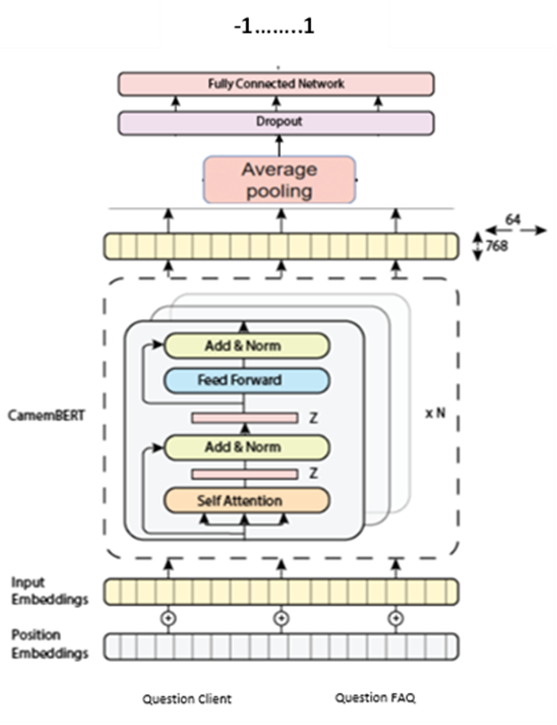

In [ ]:
#Mean Pooling - Take attention mask into account for correct averaging
def mean_pooling(token_embeddings, attention_mask):
    #token_embeddings = model_output[0] #First element of model_output contains all token embeddings
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)

In [ ]:
class CamemBERTModel(nn.Module):
  def __init__(self):
    super(CamemBERTModel, self).__init__()
    self.camembert = Config.MODEL
    self.camembert_drop = nn.Dropout(0.3)
    self.regressor = nn.Linear(768, 1)

  def forward(self, input_ids, attention_mask):
    sequence_output, pooled_output = self.camembert(input_ids=input_ids, attention_mask=attention_mask)
    mean_pool = mean_pooling(sequence_output, attention_mask)
    #rbo = self.camembert_drop(mean_pool)
    output = self.regressor(mean_pool)
    
    return output

### Engine

In [ ]:
def loss_fn(outputs, labels):
  return nn.MSELoss()(outputs, labels.view(-1, 1))

def train_fn(train_dataloader, model, optimizer, device, scheduler):
  model.train()
  final_loss = 0

  fin_labels = []
  fin_outputs = []
  for bi, d in tqdm(enumerate(train_dataloader), total=len(train_dataloader)):
    input_ids = d["input_ids"]
    attention_mask = d["attention_mask"]
    labels = d["labels"]

    input_ids = input_ids.to(device, dtype=torch.long)
    attention_mask = attention_mask.to(device, dtype=torch.long)
    labels = labels.to(device, dtype = torch.float)

    optimizer.zero_grad()
    outputs = model(input_ids=input_ids, attention_mask=attention_mask)
    loss = loss_fn(outputs, labels)
    
    final_loss += loss.item()
    fin_labels.extend(labels.cpu().detach().numpy().tolist())
    #fin_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())
    fin_outputs.extend(outputs.cpu().detach().numpy().tolist())
    
    loss.backward()
    optimizer.step()
    scheduler.step()

  return fin_outputs, fin_labels, final_loss/len(train_dataloader)

def eval_fn(valid_dataloader, model, device):
  model.eval()
  final_loss = 0

  fin_labels = []
  fin_outputs = []
  with torch.no_grad():
    for bi, d in tqdm(enumerate(valid_dataloader), total=len(valid_dataloader)):
      input_ids = d["input_ids"]
      attention_mask = d["attention_mask"]
      labels = d["labels"]

      input_ids = input_ids.to(device, dtype=torch.long)
      attention_mask = attention_mask.to(device, dtype=torch.long)
      labels = labels.to(device, dtype = torch.float)

      outputs = model(input_ids=input_ids, attention_mask=attention_mask)
      
      loss = loss_fn(outputs, labels)
      final_loss += loss.item()
      
      fin_labels.extend(labels.cpu().detach().numpy().tolist())
      #fin_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())
      fin_outputs.extend(outputs.cpu().detach().numpy().tolist())
      

  return fin_outputs, fin_labels, final_loss/len(valid_dataloader)

### Train

In [ ]:
dfx = pd.read_csv(Config.TRAINING_DATA).fillna("none")
df_train = pd.read_csv(Config.TRAINING_DATA).fillna("none")
df_valid = test_samples

"""df_train, df_valid = model_selection.train_test_split(
    dfx, test_size=0.2, random_state=42) #stratify=dfx.similarity_score.values)"""

df_train = df_train.reset_index(drop=True)
df_valid = df_valid.reset_index(drop=True)

train_dataset = STS(
    sent1=df_train.sentence1.values, 
    sent2=df_train.sentence2.values, 
    label=df_train.similarity_score.values
)
train_dataloader = DataLoader(train_dataset, batch_size=Config.TRAIN_BATCH_SIZE, num_workers=4)

valid_dataset = STS(
    sent1=df_valid.sentence1.values, 
    sent2=df_valid.sentence2.values, 
    label=df_valid.similarity_score.values
)
valid_dataloader = DataLoader(valid_dataset, batch_size=Config.VALID_BATCH_SIZE, num_workers=1)

model = CamemBERTModel()
model.to(Config.DEVICE)

param_optimizer = list(model.named_parameters())
no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
optimizer_parameters = [
                        {
                            "params": [
                                       p for n, p in param_optimizer if not any(nd in n for nd in no_decay)
                                       ],
                         "weight_decay": 0.001,
                         },
                        {
                            "params": [
                                       p for n, p in param_optimizer if any(nd in n for nd in no_decay)
                                       ],
                         "weight_decay": 0.0,
                         },
                        ]

num_train_steps = int(len(df_train) / Config.TRAIN_BATCH_SIZE * Config.EPOCHS)
optimizer = AdamW(optimizer_parameters, lr=3e-5)
scheduler = get_linear_schedule_with_warmup(
    optimizer, num_warmup_steps=0, num_training_steps=num_train_steps
    )

In [ ]:
history = defaultdict(list)
best_accuracy = 0
for epoch in range(1, 4):
  train_outputs, train_labels, train_loss = train_fn(train_dataloader, model, optimizer, Config.DEVICE, scheduler)
  valid_outputs, valid_labels, valid_loss = eval_fn(valid_dataloader, model, Config.DEVICE)

  train_accuracy = metrics.r2_score(train_labels, train_outputs)
  valid_accuracy = metrics.r2_score(valid_labels, valid_outputs)
  train_pearson_corr = scipy.stats.pearsonr(train_labels, train_outputs)[0][0]
  valid_pearson_corr= scipy.stats.pearsonr(valid_labels, valid_outputs)[0][0]

  print(f"Epoch: {epoch}\nTrain Loss: {train_loss} - Train r2_score: {train_accuracy} - Train pearson Correlation: {train_pearson_corr} \nValid Loss: {valid_loss} - Valid r2_score: {valid_accuracy}- Valid pearson Correlation: {valid_pearson_corr}\n")
  
  history['Train Loss'].append(train_loss)
  history['Train Accuracy'].append(train_accuracy)
  history['Valid Loss'].append(valid_loss)
  history['Valid Accuracy'].append(valid_accuracy)
  history['Train Pearson correlation'].append(train_pearson_corr)
  history['Valid Pearson correlation'].append(valid_pearson_corr)
  
  if valid_pearson_corr > best_accuracy:
    torch.save(model.state_dict(), Config.MODEL_PATH)
    best_accuracy = valid_pearson_corr

100%|██████████| 345/345 [00:07<00:00, 47.90it/s]


Epoch: 1
Train Loss: 0.033760979738499244 - Train r2_score: 0.6149761724730249 - Train pearson Correlation: 0.7845522048373851 
Valid Loss: 0.03292609365645162 - Valid r2_score: 0.6459224767534691- Valid pearson Correlation: 0.8254199292618746



100%|██████████| 345/345 [00:07<00:00, 47.18it/s]


Epoch: 2
Train Loss: 0.01599856909003203 - Train r2_score: 0.8167434464174205 - Train pearson Correlation: 0.9038090725943732 
Valid Loss: 0.02902337975304007 - Valid r2_score: 0.6878749421820307- Valid pearson Correlation: 0.8340663950535151



100%|██████████| 345/345 [00:07<00:00, 48.07it/s]

Epoch: 3
Train Loss: 0.013526791692504616 - Train r2_score: 0.8450564699986072 - Train pearson Correlation: 0.9196080864301532 
Valid Loss: 0.02902337975304007 - Valid r2_score: 0.6878749421820307- Valid pearson Correlation: 0.8340663950535151



### Error Analysis & Performance auditing

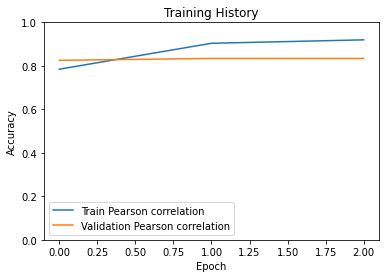

In [ ]:
plt.plot(history['Train Pearson correlation'], label='Train Pearson correlation')
plt.plot(history['Valid Pearson correlation'], label='Validation Pearson correlation')
plt.title('Training History')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

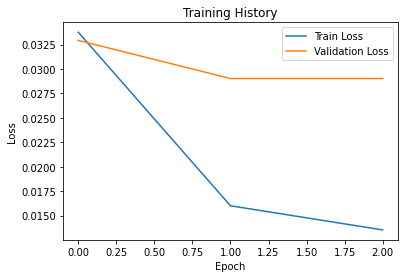

In [ ]:
plt.plot(history['Train Loss'], label='Train Loss')
plt.plot(history['Valid Loss'], label='Validation Loss')
plt.title('Training History')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()


### Inference

In [ ]:
model = CamemBERTModel()
model.to(Config.DEVICE)
model.load_state_dict(
    torch.load(
        Config.MODEL_PATH,
        map_location=torch.device(Config.DEVICE)
        )
    )

def predict(sent1: str, sent2: str):
  data = DataProcess(sent1, sent2)
  input_ids, attention_mask = data.preprocess_bert()
  
  input_ids = input_ids.to(Config.DEVICE, dtype=torch.long)
  attention_mask = attention_mask.to(Config.DEVICE, dtype=torch.long)
  
  output = model(input_ids, attention_mask)
  similarity_score = data.preprocess_output(output)
  
  return {
      "sentence1": sent1,
      "sentence2": sent2,
      "similarity Score": str(similarity_score)
      #"no similarity Score": str(no_similarity_Score),
  }

In [ ]:
sentence1 = "je suis heureux"
sentence2 = "je suis triste"

similarity_score = predict(sentence1, sentence2)
print(similarity_score)

{'sentence1': 'je suis heureux', 'sentence2': 'je suis triste', 'similarity Score': '[[0.2976442]]'}


Inference : FAQ CMR

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
faq = pd.read_excel('/content/drive/MyDrive/FAQ-CMR.xlsx')
faq.head()

,Question,Réponse,Catégorie
0,"Je suis un fonctionnaire, comment m’affilier au régime des pensions civiles/militaires ?","Vous n'avez aucune démarche à faire pour cette affiliation, c’est votre administration qui s’en charge.",Affiliation
1,"J’étais un agent dans une collectivité territoriale (budget autonome) avant mon intégration à la fonction publique de l’état,est-ce que toutes mes années de services seront prises en considération lors du calcul de ma pension?","Oui, toutefois, vous devez informer votre Administration actuelle de cette situation, afin de constituer un dossier pour la prise en compte des services accomplis dans la collectivité territoriale.",Affiliation
2,"La date de naissance portée sur mon attestation d’affiliation n’est pas conforme à celle sur ma Carte d’Identité Nationale, comment la rectifier ?","En cas de discordance, merci de contacter votre Administration afin de nous communiquer, une copie de l’extrait de votre acte de naissance que contient votre dossier de recrutement.",Affiliation
3,Quelles sont les conditions nécessaires pour l’affiliation au Régime Attakmili ?,"Tous les affiliés aux régimes de base de gérés par la CMR, peuvent s’affilier au régime Attakmili en remplissant une demande d’affiliation et une autorisation de précompte téléchargeables sur notre Portail.",Attakmili
4,Quel est la cotisation minimale au titre du Régime Attakmili ?,La cotisation minimale est de 50 DHS,Attakmili


In [ ]:
query = "j'ai un nouveau bébé, comment je fais l'inscription ?"

def predict_(sent1: str, sent2: str):
  data = DataProcess(sent1, sent2)
  input_ids, attention_mask = data.preprocess_bert()
  
  input_ids = input_ids.to(Config.DEVICE, dtype=torch.long)
  attention_mask = attention_mask.to(Config.DEVICE, dtype=torch.long)
  
  outputs = model(input_ids, attention_mask)
  similarity_score = data.preprocess_output(outputs) 
  
  return similarity_score

question=[]
scores = []
for idx in range(faq.shape[0]):
  score = predict_(query,str(faq['Question'][idx]))[0][0]
  scores.append(score)
  question.append(faq['Question'][idx])
  


In [ ]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)

In [ ]:
df = pd.DataFrame(list(zip(question, scores)),
               columns =['Question', 'similarity_score'])
df.sort_values(by='similarity_score', axis=0, ascending=False).head(5)

,Question,similarity_score
63,Comment faut-il procéder pour inscrire de nouvelles naissances ?,0.646117
27,Comment faut-il procéder pour inscrire de nouvelles naissances ?,0.646117
20,Quand est-ce que je bénéficierais du premier paiement au tire de pension de retraite? Le paiement de la première échéance de votre pension de retraite est effectué le mois suivant votre départ à la retraite par virement bancaire.,0.460244
40,Quelles sont les pièces à fournir à la CMR pour bénéficMR pour bénéficier de la réversion de l’allocation spéciale et Garde Royale?cier de la réversion temporaire de la pension d’un incarcéré. Quelles sont les pièces à fournir à la,0.438098
12,"Actuellement je suis affilié au régime des pension civiles (ou militaires) et je dispose d’une période d’affiliation au RCAR , quelle est ma position vis à vis de la Caisse ?",0.433098


In [ ]:
query2= "j'ai deux bébé, l'un est handicapé et l'autre normal, quelles sont les procédures d'inscription ? "

question1=[]
scores1 = []
for idx in range(faq.shape[0]):
  score = predict_(query2,str(faq['Question'][idx]))[0][0]
  scores1.append(score)
  question1.append(faq['Question'][idx])

In [ ]:
df = pd.DataFrame(list(zip(question1, scores1)),
               columns =['Question', 'similarity_score'])
df.sort_values(by='similarity_score', axis=0, ascending=False).head(5)

,Question,similarity_score
26,ِComment faut-il procéder pour inscrire des enfants handicapés ?,0.513010
53,Quelles sont les pièces à fournir à la CMR pour bénéficier de la réversion de la pension d’invalidité au profit de l’enfant handicapé?,0.455556
34,"Je suis orphelin(e) handicapé(e), je voudrai bénéficier de la réversion de la pension d’invalidité. Quelles sont les pièces que je dois fournir à la CMR ?",0.422732
43,Quelles sont les pièces à fournir à la CMR pour bénéficier de la réversion temporaire de la Pension de Résistant Invalide (PRI) en cas de disparition du résistant?,0.416040
59,Quelle est la démarche à suivre pour bénéficier d'une pension d'invalidité ?,0.405250


## Cross Encoder : Camembert + LSTM_LastVector

In [ ]:
class CamemBERTLstmModel(nn.Module):
  def __init__(self):
    super(CamemBERTLstmModel, self).__init__()
    self.camembert = Config.MODEL
    self.lstm = nn.LSTM(768, 768, batch_first=True)
    self.camembert_drop = nn.Dropout(0.2)
    self.regressor = nn.Linear(768, 1)

  def forward(self, input_ids, attention_mask):
    sequence_output, pooled_output = self.camembert(input_ids=input_ids, attention_mask=attention_mask)
    lstm_output, (h,c) = self.lstm(sequence_output)
    rbo = self.camembert_drop(lstm_output[:,-1].view(-1, 768))
    output = self.regressor(rbo)
    
    return output

In [ ]:
#dfx = pd.read_csv(Config.TRAINING_DATA).fillna("none")
df_train = pd.read_csv(Config.TRAINING_DATA).fillna("none")
df_valid = test_samples

'''df_train, df_valid = model_selection.train_test_split(
    dfx, test_size=0.2, random_state=42) #stratify=dfx.similarity_score.values)'''

df_train = df_train.reset_index(drop=True)
df_valid = df_valid.reset_index(drop=True)

train_dataset = STS(
    sent1=df_train.sentence1.values, 
    sent2=df_train.sentence2.values, 
    label=df_train.similarity_score.values
)
train_dataloader = DataLoader(train_dataset, batch_size=Config.TRAIN_BATCH_SIZE, num_workers=4)

valid_dataset = STS(
    sent1=df_valid.sentence1.values, 
    sent2=df_valid.sentence2.values, 
    label=df_valid.similarity_score.values
)
valid_dataloader = DataLoader(valid_dataset, batch_size=Config.VALID_BATCH_SIZE, num_workers=1)

model_lstm = CamemBERTLstmModel()
model_lstm.to(Config.DEVICE)

param_optimizer = list(model_lstm.named_parameters())
no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
optimizer_parameters = [
                        {
                            "params": [
                                       p for n, p in param_optimizer if not any(nd in n for nd in no_decay)
                                       ],
                         "weight_decay": 0.001,
                         },
                        {
                            "params": [
                                       p for n, p in param_optimizer if any(nd in n for nd in no_decay)
                                       ],
                         "weight_decay": 0.0,
                         },
                        ]

num_train_steps = int(len(df_train) / Config.TRAIN_BATCH_SIZE * Config.EPOCHS)
optimizer = AdamW(optimizer_parameters, lr=3e-5)
scheduler = get_linear_schedule_with_warmup(
    optimizer, num_warmup_steps=0, num_training_steps=num_train_steps
    )

In [ ]:
history2 = defaultdict(list)
best_accuracy = 0
for epoch in range(1, 4):
  train_outputs, train_labels, train_loss = train_fn(train_dataloader, model_lstm, optimizer, Config.DEVICE, scheduler)
  valid_outputs, valid_labels, valid_loss = eval_fn(valid_dataloader, model_lstm, Config.DEVICE)

  train_accuracy = metrics.r2_score(train_labels, train_outputs)
  valid_accuracy = metrics.r2_score(valid_labels, valid_outputs)
  train_pearson_corr = scipy.stats.pearsonr(train_labels, train_outputs)[0][0]
  valid_pearson_corr= scipy.stats.pearsonr(valid_labels, valid_outputs)[0][0]

  print(f"Epoch: {epoch}\nTrain Loss: {train_loss} - Train r2_score: {train_accuracy} - Train pearson Correlation: {train_pearson_corr} \nValid Loss: {valid_loss} - Valid r2_score: {valid_accuracy}- Valid pearson Correlation: {valid_pearson_corr}\n")
  
  history2['Train Loss'].append(train_loss)
  history2['Train Accuracy'].append(train_accuracy)
  history2['Valid Loss'].append(valid_loss)
  history2['Valid Accuracy'].append(valid_accuracy)
  history2['Train Pearson correlation'].append(train_pearson_corr)
  history2['Valid Pearson correlation'].append(valid_pearson_corr)
  
  if valid_pearson_corr > best_accuracy:
    torch.save(model_lstm.state_dict(), Config.MODEL_LSTM_PATH)
    best_accuracy = valid_pearson_corr

100%|██████████| 345/345 [00:09<00:00, 37.63it/s]


Epoch: 1
Train Loss: 0.019700740184737605 - Train r2_score: 0.7743515347300415 - Train pearson Correlation: 0.8806836914975563 
Valid Loss: 0.03874077983622345 - Valid r2_score: 0.583260615683616- Valid pearson Correlation: 0.8279914090133285



100%|██████████| 345/345 [00:09<00:00, 37.60it/s]


Epoch: 2
Train Loss: 0.010049962220251943 - Train r2_score: 0.8848885743908993 - Train pearson Correlation: 0.9407656569201034 
Valid Loss: 0.02959994425089436 - Valid r2_score: 0.681613960313804- Valid pearson Correlation: 0.8382655954551449



100%|██████████| 345/345 [00:09<00:00, 37.45it/s]


Epoch: 3
Train Loss: 0.008541692663695203 - Train r2_score: 0.902165840717555 - Train pearson Correlation: 0.9500686343602808 
Valid Loss: 0.02959994425089436 - Valid r2_score: 0.681613960313804- Valid pearson Correlation: 0.8382655954551449



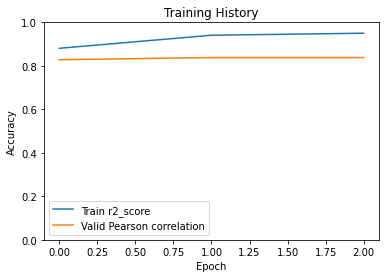

In [ ]:
plt.plot(history2['Train Pearson correlation'], label='Train r2_score')
plt.plot(history2['Valid Pearson correlation'], label='Valid Pearson correlation')
plt.title('Training History')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

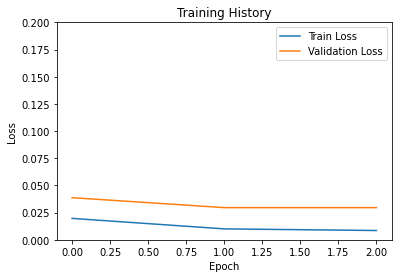

In [ ]:
plt.plot(history2['Train Loss'], label='Train Loss')
plt.plot(history2['Valid Loss'], label='Validation Loss')
plt.title('Training History')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 0.2]);

### Inference

In [ ]:
model_lstm = CamemBERTLstmModel()
model_lstm.to(Config.DEVICE)
model_lstm.load_state_dict(
    torch.load(
        Config.MODEL_LSTM_PATH,
        map_location=torch.device(Config.DEVICE)
        )
    )

def predict(sent1: str, sent2: str):
  data = DataProcess(sent1, sent2)
  input_ids, attention_mask = data.preprocess_bert()
  
  input_ids = input_ids.to(Config.DEVICE, dtype=torch.long)
  attention_mask = attention_mask.to(Config.DEVICE, dtype=torch.long)
  
  output = model_lstm(input_ids, attention_mask)
  similarity_score = data.preprocess_output(output)
  
  return {
      "sentence1": sent1,
      "sentence2": sent2,
      "similarity Score": str(similarity_score)
      #"no similarity Score": str(no_similarity_Score),
  }

In [ ]:
sentence1 = "je suis heureux"
sentence2 = "je suis triste"

similarity_score = predict(sentence1, sentence2)
print(similarity_score)

{'sentence1': 'je suis heureux', 'sentence2': 'je suis triste', 'similarity Score': '[[0.36683512]]'}


In [ ]:
query = " est ce que je peux modifier mon nom ?"

def predict_(sent1: str, sent2: str):
  data = DataProcess(sent1, sent2)
  input_ids, attention_mask = data.preprocess_bert()
  
  input_ids = input_ids.to(Config.DEVICE, dtype=torch.long)
  attention_mask = attention_mask.to(Config.DEVICE, dtype=torch.long)
  
  outputs = model_lstm(input_ids, attention_mask)
  similarity_score = data.preprocess_output(outputs) 
  
  return similarity_score

question=[]
scores = []
for idx in range(faq.shape[0]):
  score = predict_(query,str(faq['Question'][idx]))[0][0]
  scores.append(score)
  question.append(faq['Question'][idx])
  


In [ ]:
df = pd.DataFrame(list(zip(question, scores)),
               columns =['Question', 'similarity_score'])
df.sort_values(by='similarity_score', axis=0, ascending=False).head(5)

,Question,similarity_score
29,Comment faut-il procéder pour changer mon nom ?,0.819282
28,Comment faut-il procéder pour rectifier mon nom?,0.760143
40,Quelles sont les pièces à fournir à la CMR pour bénéficMR pour bénéficier de la réversion de l’allocation spéciale et Garde Royale?cier de la réversion temporaire de la pension d’un incarcéré. Quelles sont les pièces à fournir à la,0.522452
6,Puis-je modifier ou suspendre mes cotisations ?,0.518026
76,"Je suis bénéficiaire d'une pension de retraire, quels sont les changements dans ma situation que je dois communiquer à la Caisse Marocaine des Retraites ?",0.469596


### References
* **Louis Martin, Benjamin Muller, Pedro Javier Ortiz Suárez, Yoann Dupont, Laurent Romary, Éric Villemonte de la Clergerie, Djamé Seddah, Benoît Sagot. 2019. [CamemBERT: a Tasty French Language Model](https://arxiv.org/abs/1911.03894). arXiv preprint arXiv:1911.03894**